Reload configuration
-----------
First reload everything as per "RegressionBasic.ipynb".  True function, *etc.*, redefined here as well.

In [1]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy
import sys
import os
sys.path.append(os.getcwd())
import regressiondemo as rd

##############################
#      Customize the demo here
#      =======================
# the "true" function of x with range fixed at [0,10]
def truefunc(x):
    return numpy.sin(x*2.0)*numpy.sqrt(x)/3.3

#  when fitting goes wild, need to constrain what y's are plotted
#  must be compatible with "true" function
ydisplaymin = -1.8
ydisplaymax = 1.8

#  don't make points more than 100 as demo is O(points^3)
points = 30

#  noise level (std.dev)
rd.setSigma(0.2)
##############################

x = rd.makeX(points)
#  build the true values matching the sampled data

y = rd.addNoise(truefunc(x))

# xts and yts store the "true" function for the purposes of plotting
# these have to be high frequency to make the resultant plot look
# like a smooth curve
xts = rd.makeX(200,uniform=True)
yts = truefunc(xts)

## Step 1.1:  Fitting different orders of polynomials
Now we will try regression this for a whole range of orders, different degrees of the polynomial.  This means generating a set of *orders*.  We do this by starting with a maximum order given by a bit less than *points* and then halve until the order shrinks to 3.  Now we repeat the above code for the different orders.

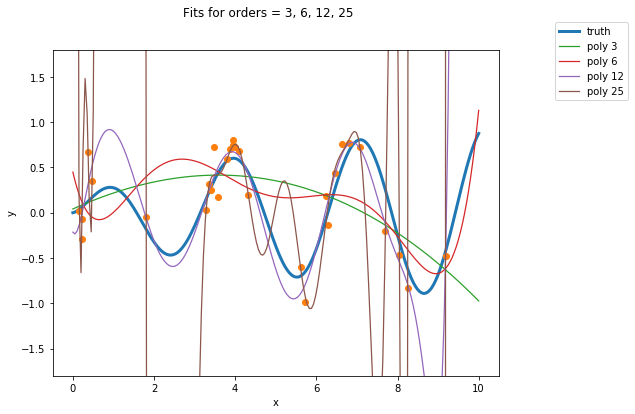

In [2]:
# make canvas size a bit bigger (in inches)
bigcanvas = [8,6]
pl.figure(figsize=bigcanvas)

# plot data and the truth
pl.plot(xts, yts,label = 'truth', linewidth=3.0) # default is green line? 
pl.plot(x, y, 'o') 
pl.ylabel('y')
pl.xlabel('x')

#  build a set of polynomial orders to use to fit
orders = rd.makeOrders(points)
#  print 'Fitting polynomials of orders = ', orders
        
for order in orders:
    #  build the fitted poly curve 
    ys = rd.linReg(x,y,xts,order)

    #  plot fitted curve
    pl.plot(xts, ys, label = 'poly ' + str(order), linewidth=1.25 )  
    
#  the y range for the plot has to be altered depending on the data
pl.ylim(ydisplaymin,ydisplaymax)

# move the legend out of the way
# the (1.2, 1.2) starts the legend at the location relative to
# the top right corner
pl.legend(bbox_to_anchor=(1.3, 1.1))
pl.suptitle('Fits for orders = '+ ', '.join(map(str, orders)) )

So, what do you see above with the different dimensional polynomials?  How well do higher dimensional polynomials work? Which order seems to give the best fit?  The low order polynomial is way too simple and the high order polynomial, with almost as much coefficients as data, goes wild.

## Step 1.2:  How well can linear regression fit the "truth" anyway?
In order to understand how well any particular polynomial order can do, we can try generating a large number of points with little noise and see how well a polynomial of that order fits the (near-enough to) "infinite" sample.   Note in practice we can rarely do this because we rarely have an infinite sample of data; nor do we know the "truth".  So this is a "what if" scenario used to test out what happens with models of different orders.

Fitting polynomials of orders =  [3, 6, 12, 25]


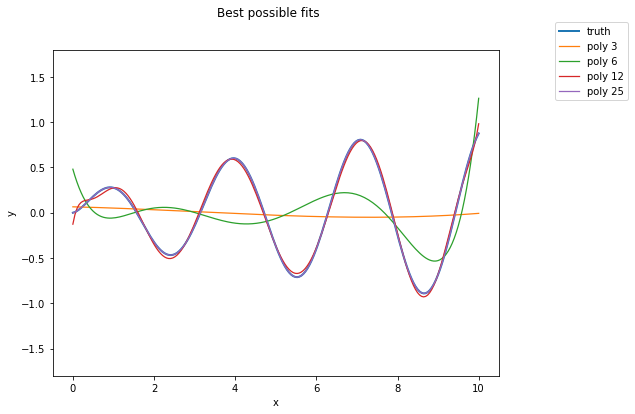

In [3]:
# plot the truth
pl.figure(figsize=bigcanvas)
pl.plot(xts, yts,label = 'truth', linewidth=2) # default is green line? 
pl.ylabel('y')
pl.xlabel('x')

print ("Fitting polynomials of orders = ", orders)
        
for order in orders:
    # fit the (approx) best polynomial
    ys = rd.bestLinReg(truefunc,xts,order)

    #  plot fitted curve
    pl.plot(xts, ys,label = 'poly ' + str(order), linewidth=1.25 )  
    
#  the y range for the plot has to be altered depending on the data
pl.ylim(ydisplaymin,ydisplaymax)

# move the legend out of the way
# the (1.2, 1.2) starts the legend at the location relative to
# the top right corner
pl.legend(bbox_to_anchor=(1.3, 1.1))
pl.suptitle('Best possible fits')

So these curves represent the (near) best fits one can do to the "truth" with different orders of polynomials.  These best fits are in the sense of "least squares", the least squared error averaged over the $x$-range.  When fitting to finite samples, one will get more or less close to these best fits, the less data one has then generally the worse the fit will be.

So you should see that the higher orders of polynomial the best fit matches the true function.  There is an order of polynomial where the best possible fit becomes indistinguishable to the eye on these plots.  However, consider again  the "fits of different orders" plot.  For the higher orders, these fits (with a smallish amount of data) are not even close to the best possible fit.

## Model bias
This leads to some important concepts in statistical learning:

**Model family**: a model family is a class of models characterised by some higher order parameters, usually called *hyper-parameters*.  In the 2-D linear regressions here, the hyper-parameter is the order.  This leads to particular members of the family, 4-th order linear regression in 2-D, 10-th order linear regression in 2-D, *etc.*  To instantiate one of these to get a particular model instance or function, we need to give the coefficients to.  So an instance of 4-th order linear regression in 2-D would be fully instantiated with the 5 coefficients (1,1,0.5,0.2,0.1), one for the constant term and 4 for the powers.

**Bias**: how close can a particular member of the model family fit a particular "truth".  So for the curve *sin(x)* on some range [0,5], how close can one get with a 4-th order polynomial or a 10-th order polynomial?  We plotted the best fits in the previous cell.

**Large bias models**:  so small order polynomials can never fit the *sin(x)* function very well.  These members of the linear regression family are said to have *large bias*.

**Small bias models**:  so large order polynomials can usually fit the *sin(x)* function much better.  These members of the linear regression family are said to have *small bias*.

In general, **simple** models will have a large bias, and **complex** models will have a small bias.  But our problem is that we *don't* know the "truth", we just have a finite sample of data.  So we never quite know just how complex a model we should use.  In principle the complex model *can* fit the data well, but will it on a finite sample?

## Step 1.3:  The effect of different samples
Now another aspect of simple and complex models is how differently they behave with different data sets.  We saw a glimmer of this in an earlier plot, but here we will develop the comparison more.  Again, its important to keep in mind we cannot do this in practice, since usually we have one finite sample.  We do it here as part of a "what if" scenario in the unlikely situation where the "truth" is given.

So lets try a bunch of different samples of the same size, and see how well the different orders of polynomials do.  For this, we'll just use the largest four orders of the set of orders above.  

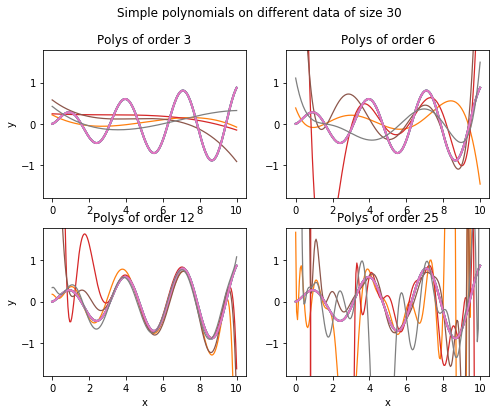

In [4]:
#  we do a 2x2 plot, so need for orders to fit
fourorders = orders[-4:]
#  set this above vector to any four descreasing numbers
#  starting with 3 or more, and not too big (<100)
#     e.g.,   fourorders = [3,6,10,20]

#  print 'Fitting polynomials of orders = ', fourorders

setcount = 5
    
pl.figure(figsize=bigcanvas)
pl.suptitle( 'Simple polynomials on different data of size '+str(points))
for s in range(1,setcount):
    # generate another sample
    xb = rd.makeX(points)
    yb = rd.addNoise(truefunc(xb))
    #  build the fitted poly curve 
    sp = 1;
    for order in fourorders:
        pl.subplot(2,2,sp)
        sp += 1

        # plot the truth
        pl.plot(xts, yts, linewidth=2) # default is green line? 
        if sp>3:
            pl.xlabel('x')
        if sp%2==0:
            pl.ylabel('y')

        ys = rd.linReg(xb,yb,xts,order)

        #  plot fitted curve
        pl.plot(xts, ys, linewidth=1.25 )  
        pl.title('Polys of order ' + str(order))
    
        #  the y range for the plot has to be altered depending on the data
        pl.ylim(ydisplaymin,ydisplaymax)

The key thing to notice about this plot is the variability of the curves for the different orders of polynomials. One can measure this variability in different ways, to measure in some sense the difference between the different fits. Notice for the low order polynomial, the fits are similar to each other but all quite different from the "truth". In constrast, the high order polynomials oftentimes have good fits to the "truth" but in some places they go wild, and differ markedly between each other.

The standard measure of difference is the so-called variance:
> **Variance** is the mean square error between each fitted curve and the best possible fitted 
> curve (built with the same algorithm but using "infinite" data).

Variance measures difference between fitted curves and not difference from the truth. For simple models with large bias, the variance is small. For complex models with small bias, the variance would be small except for the occasion when it goes wild, leading to a large variance overall.